In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve

In [2]:
def parse_datafile(path):
    data = np.loadtxt(path, dtype=str)

    labels = data[:, 1].astype(int)
    features = np.array([[int(digit) for digit in row[2]] for row in data if row[2].isdigit()])

    return features, labels

X, Y = parse_datafile("SpamInstances.txt")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

In [3]:
# classify featuresets based on their status as either spam or not-spam
yspam = X_train[Y_train == 1]
nspam = X_train[Y_train == -1]

u_yspam = np.mean(yspam)
u_nspam = np.mean(nspam)

# probabilities of each feature being present (v=1) given the email is either spam or not-spam.
# they are put through 'Laplace Smoothing' to avoid zero probabilities when a feature does not
# appear in an instance: P(w|c) = (count(w, c) + 1) / (count(c) + V)
X_yspam = (np.sum(yspam, axis=0) + 1) / (yspam.shape[0] + 2)
X_nspam = (np.sum(nspam, axis=0) + 1) / (nspam.shape[0] + 2)

In [4]:
# for each email, it computes two 'Long-Posterior Probabilities' (spam and non-spam) as the log
# of the prior probability of the class [log P(y)] plus the sum of 'Log-Likelihoods' of each
# feature conditioned on that class, using a 'Bernoulli Distribution' due to binary features.
Y_hat = np.zeros(X_test.shape[0])
prob = np.zeros(X_test.shape[0])
for i, x in enumerate(X_test):
    yspam_score = np.log(u_yspam) + np.sum(x * np.log(X_yspam) + (1 - x) * np.log(1 - X_yspam))
    nspam_score = np.log(u_nspam) + np.sum(x * np.log(X_nspam) + (1 - x) * np.log(1 - X_nspam))
    Y_hat[i] = 1 if yspam_score > nspam_score else -1
    prob[i] = 1 / (1 + np.exp(nspam_score - yspam_score))

print(f"Accuracy {round(np.mean(Y_hat == Y_test) * 100, 2)}%")
print(f"Probability {prob}")

Accuracy 97.9%
Probability [9.99983583e-01 3.12902147e-08 1.00000000e+00 ... 2.29842731e-05
 1.52661852e-10 2.05635627e-07]


In [5]:
model_accuracy = []
model_percision = []
model_recall = []
fpr_list = []
tpr_list = []

for size in range(100, 12401, 100):
    idx = np.random.choice(X.shape[0], size, replace=False)

    X, Y = parse_datafile("SpamInstances.txt")
    X_train, X_test, Y_train, Y_test = train_test_split(X[idx], Y[idx], test_size=0.2, random_state=42, shuffle=True)

    # classify featuresets based on their status as either spam or not-spam
    yspam = X_train[Y_train == 1]
    nspam = X_train[Y_train == -1]

    u_yspam = np.mean(yspam)
    u_nspam = np.mean(nspam)

    # probabilities of each feature being present (v=1) given the email is either spam or not-spam.
    # they are put through 'Laplace Smoothing' to avoid zero probabilities when a feature does not
    # appear in an instance: P(w|c) = (count(w, c) + 1) / (count(c) + V)
    X_yspam = (np.sum(yspam, axis=0) + 1) / (yspam.shape[0] + 2)
    X_nspam = (np.sum(nspam, axis=0) + 1) / (nspam.shape[0] + 2)

    # for each email, it computes two 'Long-Posterior Probabilities' (spam and non-spam) as the log
    # of the prior probability of the class [log P(y)] plus the sum of 'Log-Likelihoods' of each
    # feature conditioned on that class, using a 'Bernoulli Distribution' due to binary features.
    Y_hat = np.zeros(X_test.shape[0])
    probs = np.zeros(X_test.shape[0])
    for i, x in enumerate(X_test):
        yspam_score = np.log(u_yspam) + np.sum(x * np.log(X_yspam) + (1 - x) * np.log(1 - X_yspam))
        nspam_score = np.log(u_nspam) + np.sum(x * np.log(X_nspam) + (1 - x) * np.log(1 - X_nspam))
        Y_hat[i] = 1 if yspam_score > nspam_score else -1
        probs[i] = 1 / (1 + np.exp(nspam_score - yspam_score))

    predictions = np.where(probs >= 0.5, 1, -1)
    model_accuracy.append(np.mean(Y_hat == Y_test))
    model_percision.append(precision_score(Y_test, predictions, pos_label=1))
    model_recall.append(recall_score(Y_test, predictions, pos_label=1))

    fpr, tpr, _ = roc_curve(Y_test, probs, pos_label=1)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

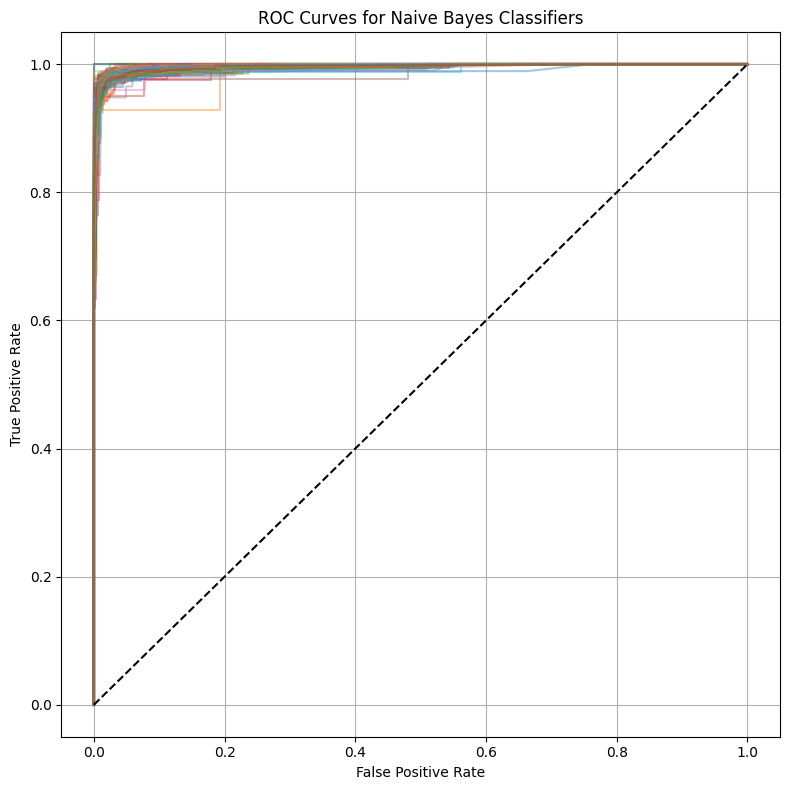

In [6]:
plt.figure(figsize=(8,8), dpi=100)
for fpr, tpr in zip(fpr_list, tpr_list):
    plt.plot(fpr, tpr, alpha=0.4)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves for Naive Bayes Classifiers')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.tight_layout()
plt.show()